In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from numba import njit,prange
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from commonfunctions import *



In [96]:
%%capture
%run  letters_extraction.ipynb

In [97]:
directory = './symbols/'

<h3>Reading directory names</h3>

In [98]:
Name=[]
for file in os.listdir(directory):
    Name+=[file]
print(Name)
print(len(Name))

['(', ')', '+', '.trash', '0', '1', 'A', 'B', 'C', 'F', '~']
11


<h4>Getting a list of unique file extensions</h4>

In [99]:
extensions = []

for path, subdirs, files in os.walk(directory):
        for name in files:
            if os.path.splitext(name)[1] not in extensions:
                extensions += [os.path.splitext(name)[1]]

print(extensions)
sorted(os.listdir(directory))

['.png', '.jpg']


['(', ')', '+', '.trash', '0', '1', 'A', 'B', 'C', 'F', '~']

<h3>Map unique strings to integers in Python. Make dictionary</h3>

In [100]:
from collections import defaultdict
d = defaultdict(int)
co = 0
for x in sorted(os.listdir(directory)):
    if not x.startswith('.') and not d[x]:
        d[x] = co
        co+=1
d

defaultdict(int,
            {'(': 0,
             ')': 1,
             '+': 2,
             '0': 3,
             '1': 4,
             'A': 5,
             'B': 6,
             'C': 7,
             'F': 8,
             '~': 9})

<h3>Resizing images</h3>

In [101]:
from skimage.morphology import skeletonize
def prepare_image(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    image = get_letters(image, single_letter=False)[0]
    return image

def images_resize(directory):
    list_target_names = []
    list_images = []
        
    for path, subdirs, files in os.walk(directory):
        if(path.startswith(directory + '.')):
            continue
        files = [f for f in files if not f[0] == '.'] # Ignore '.directory' file
        # subdirs[:] = [d for d in subdirs if not d[0] == '.'] # Ignore hidden directories
        print(path, len(files))
        limit = 600
        if len(files) > limit:
            files = files[:limit]
            
        for name in files:
            image=cv2.imread(os.path.join(path, name))
            image = prepare_image(image)
            # image=cv2.resize(image, (100, 100))
            list_target_names.append(os.path.basename(path))
            list_images.append(image)
    
    return list_target_names,  list_images 
        
target_names,images = images_resize(directory)

./symbols/ 0
./symbols/( 55
./symbols/) 55
./symbols/+ 55
./symbols/0 55
./symbols/1 55
./symbols/A 55
./symbols/B 55
./symbols/C 55
./symbols/F 54
./symbols/~ 55


In [102]:
len(target_names)

549

In [103]:
len(images)

549

In [104]:
from collections import Counter
c = Counter(sorted(target_names))

c

Counter({'(': 55,
         ')': 55,
         '+': 55,
         '0': 55,
         '1': 55,
         'A': 55,
         'B': 55,
         'C': 55,
         'F': 54,
         '~': 55})

<h3>Assign a Dictionary Value to the List <B><I>"target_names"</I></B> Based on Dictionary Key</h3>

In [105]:
target_names = [d[key] for key in target_names]

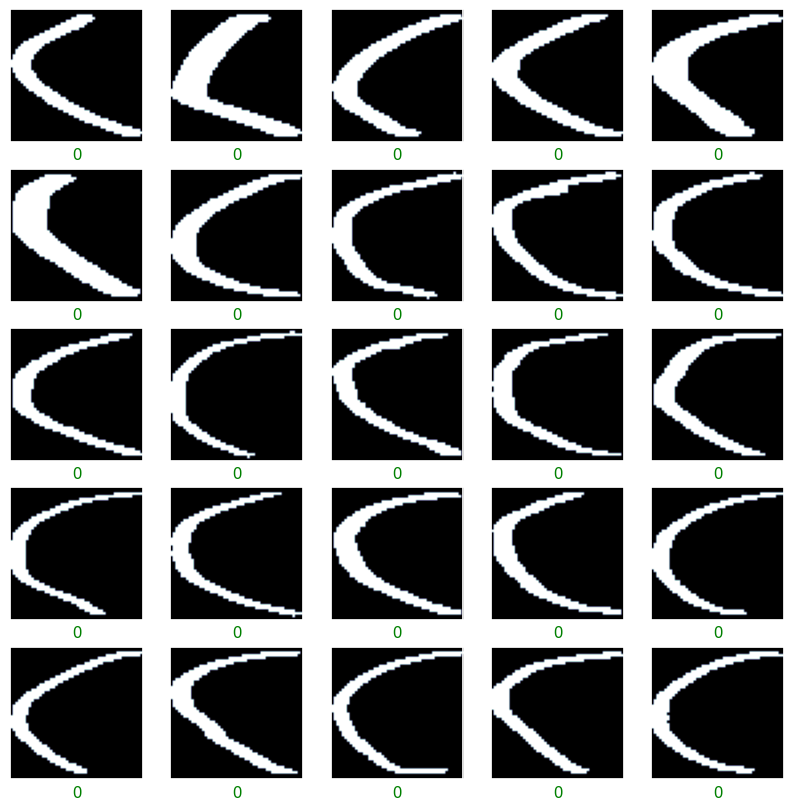

In [106]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))

for i, axi in enumerate(ax.flat):
    axi.imshow(images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=target_names[i])
    axi.xaxis.label.set_color('green')

<h4>Randomly shuffle two lists "target_names" and "images" keeping initial order</h4>

In [107]:
# target_names_shuffled, images_shuffled = shuffle(np.array(target_names, dtype=object), np.array(images, dtype=object))
target_names_shuffled, images_shuffled = shuffle(np.array(target_names), np.array(images))

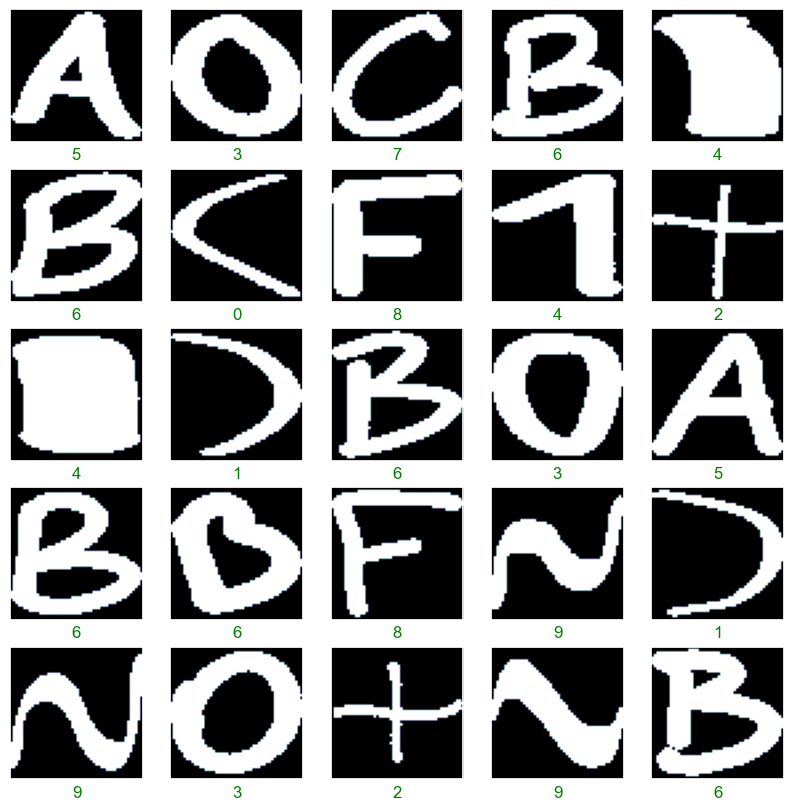

In [108]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))

for i, axi in enumerate(ax.flat):
    axi.imshow(images_shuffled[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=target_names_shuffled[i])
    axi.xaxis.label.set_color('green')

<h4>Reshaping dataframe</h4>

In [109]:
winSize = (32,32)
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9

hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
a = hog.compute(images_shuffled[0])

In [110]:
n_samples,nx,ny= images_shuffled.shape
print(images_shuffled.shape)
print(images_shuffled[0].dtype)
# images_shuffled = images_shuffled.reshape(n_samples, nx*ny)
# hog = cv2.HOGDescriptor()
hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
images_shuffled2 = np.array([hog.compute(image)  for image in images_shuffled])
# images_shuffled2 = np.array([cv2.dft(np.float32(image))  for image in images_shuffled])
images_shuffled2 = images_shuffled2.reshape(n_samples,-1)


# print(images_shuffled2[0])
# ----------- SIFT FEATURE EXTRACTION 

# from sklearn.cluster import KMeans

# dico = []

# sift = cv2.SIFT_create()
# # def step1():
# for img in images_shuffled:
#     kp, des = sift.detectAndCompute((img*255) , None)
#     des = des if des is not None else []
#     for d in des:
#         dico.append(d)


# k = 160
# print(k)
# print(len(dico))
# # batch_size = np.size(len(target_names)) * 3
# kmeans = KMeans(init='k-means++', n_clusters=k, verbose=1).fit(dico)

# # kmeans.verbose = False

# histo_list = []

# for img in images_shuffled:
#     kp, des = sift.detectAndCompute(img*255, None)

#     histo = np.zeros(k)
#     nkp = np.size(kp)
#     # print(nkp)
#     des = des if des is not None else []
#     for d in des:
#         idx = kmeans.predict([d])
#         histo[idx] += 1 # Because we need normalized histograms, I prefere to add 1/nkp directly

#     histo_list.append(histo)


(549, 50, 50)
uint8


In [111]:
# print((histo_list[0]))
# histo_list  = np.array(histo_list)
# # histo_list = histo_list * 255


In [112]:
Xtrain, Xtest, ytrain, ytest = train_test_split(images_shuffled2, target_names_shuffled, random_state=0)

In [113]:
# import numpy as np
# from joblib import parallel_backend # added line.
# from sklearn.datasets import load_digits
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.svm import SVC      
# from sklearn.ensemble import RandomForestClassifier
# from ray.util.joblib import register_ray # added line.
# register_ray() # added line.

# param_space = {
#     'C': np.logspace(-6, 6, 30),
#     'gamma': np.logspace(-8, 8, 30),
#     'tol': np.logspace(-4, -1, 30),
#     'class_weight': [None, 'balanced'],
# }

# model = RandomForestClassifier(n_estimators=1000)
# search = RandomizedSearchCV(model, param_space, cv=5, n_iter=300,verbose=1)
# # digits = load_digits()
# ray.init(address='auto')
# with parallel_backend('ray'): # added line.
#     search.fit(Xtrain, ytrain)
    
# ypred = search.predict(Xtest)


<h3>Implementing an Random Forest Classifier</h3>

In [114]:
# from sklearnex import patch_sklearn
import joblib
# patch_sklearn()

# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier(n_estimators=1000)
# model.fit(Xtrain, ytrain)
# ypred = model.predict(Xtest)

# from sklearn.tree import DecisionTreeClassifier
# clf = DecisionTreeClassifier()
# clf.fit(Xtrain, ytrain)
# ypred = clf.predict(Xtest)


from sklearn import svm
model = svm.SVC(gamma = 0.001, C =100)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

 
# import pickle
# s = pickle.dumps(model)


In [115]:
import joblib

# save the model to disk
filename = './saved_models/finalized_model.sav'
joblib.dump(model, filename)
 

['./saved_models/finalized_model.sav']

<h3>The classification report for this classifier:</h3>

In [116]:
from sklearn import metrics
# print(Xtest.shape)
print(metrics.classification_report(ytest, ypred))
print("Accuracy:",metrics.accuracy_score(ytest, ypred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        19
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00        14
           7       1.00      1.00      1.00        12
           8       0.93      1.00      0.96        13
           9       1.00      0.92      0.96        12

    accuracy                           0.99       138
   macro avg       0.99      0.99      0.99       138
weighted avg       0.99      0.99      0.99       138

Accuracy: 0.9927536231884058


<h3>Plot the confusion matrix:</h3>

Text(273.99999999999994, 0.5, 'predicted label')

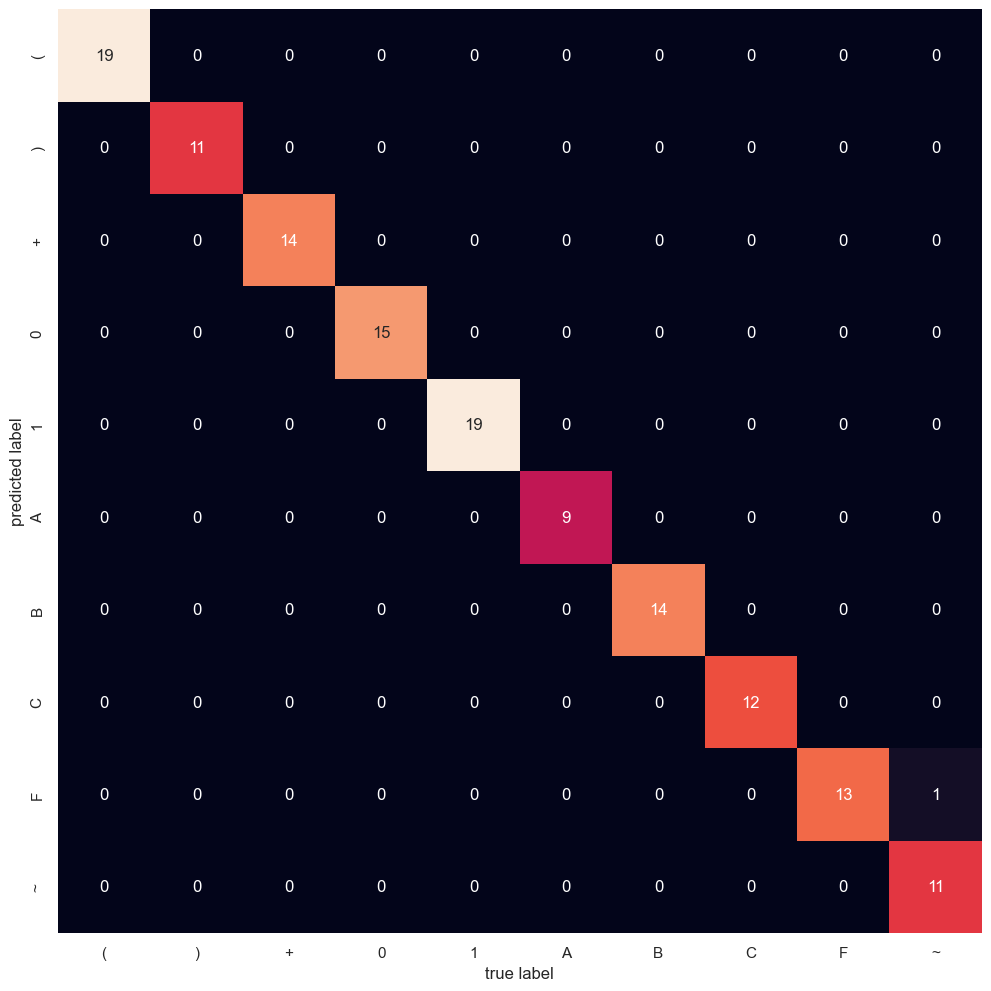

In [117]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,12)})

mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=list(d.keys()), yticklabels=list(d.keys()))


plt.xlabel('true label')
plt.ylabel('predicted label')


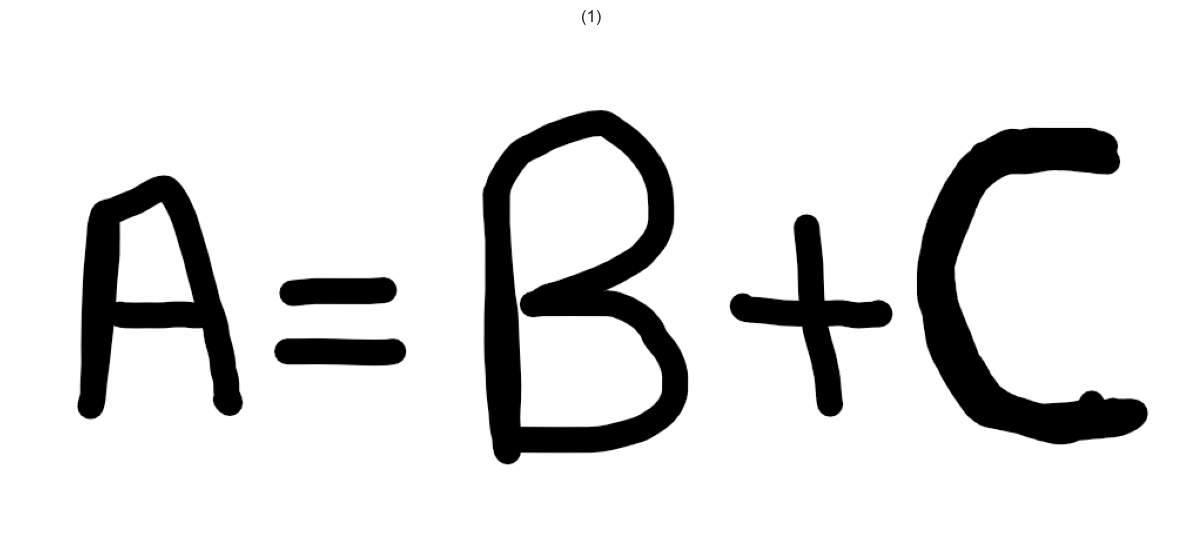

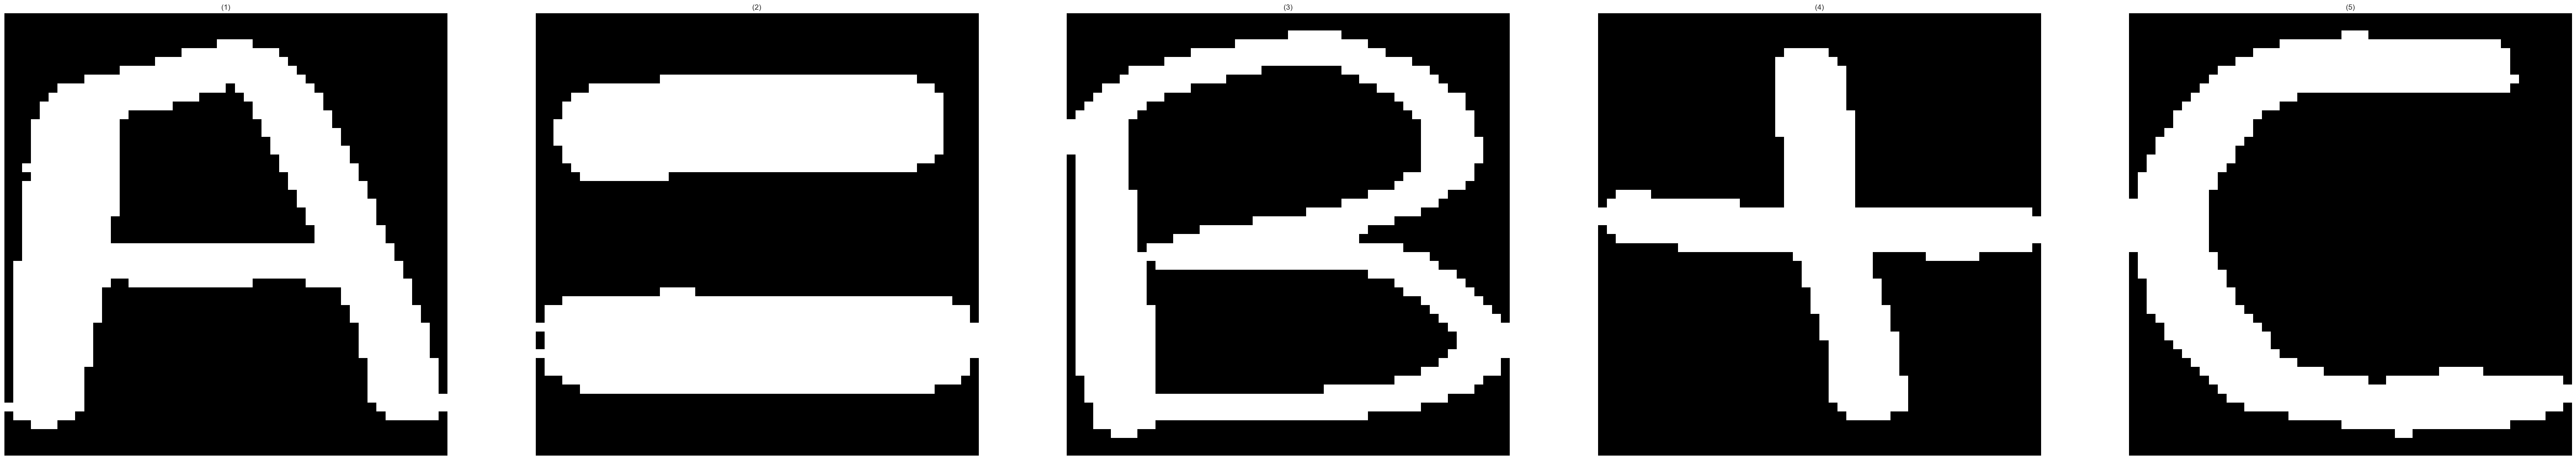

(5, 2916)
[5 8 6 2 7]
['A', 'F', 'B', '+', 'C']


In [118]:
letters= cv2.cvtColor(cv2.imread(r".\test_images\classification\A=b+c.png"), cv2.COLOR_BGR2GRAY)
show_images([letters])
letters_res = np.array(get_letters(letters, single_letter=False, verbose= False))
show_images(letters_res)
# cf.show_images([letters_res[0], get_letters(letters, single_letter=False)[0]])

# letters_res = letters_res.reshape(len(letters_res), -1)
letters_res = np.array([hog.compute(image) for image in letters_res])
print(letters_res.shape)

results = model.predict(letters_res)
print(results)
print([list(d.keys())[i] for i in results])
# inv_map = {v: k for k, v in d.items()}
# print([inv_map[i] for i in results])


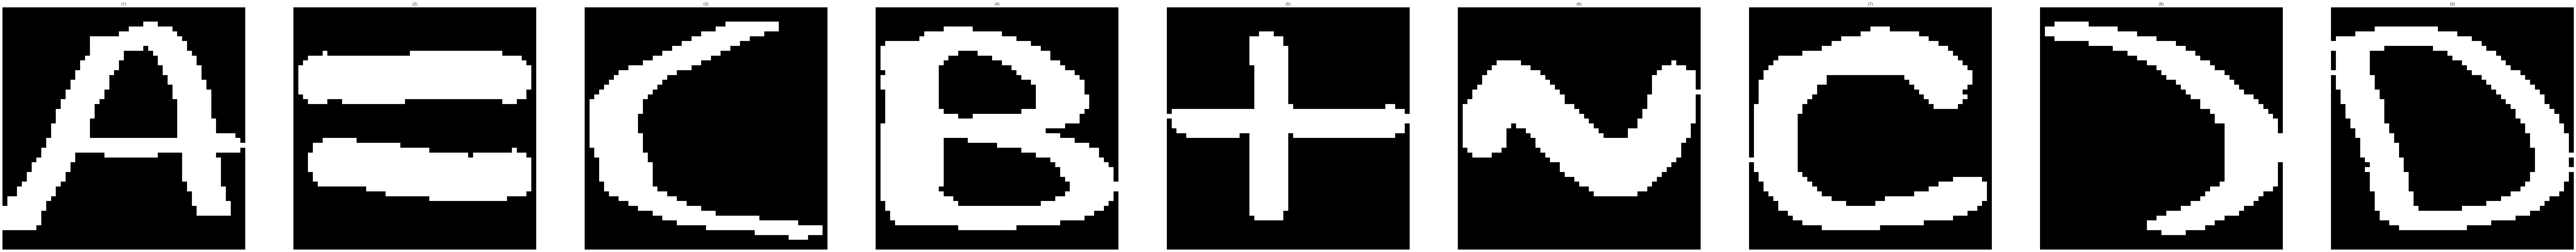

(9, 2916)
[5 8 0 6 2 9 7 1 3]
['A', 'F', '(', 'B', '+', '~', 'C', ')', '0']
['A', 'F', '(', 'B', '+', '~', 'C', ')', '0']


In [119]:
# letters= cv2.cvtColor(cv2.imread(r'D:\academic_material\third_year\imageProcessing\repos\LogIm\phase_1\datasets\symbol2\9\0ZGdgPTM.png'), cv2.COLOR_BGR2GRAY)
# letters_res = np.array(get_letters(letters, single_letter=True, verbose=True))
# cf.show_images([letters_res[0], get_letters(letters, single_letter=False,verbose=True)[0]])

letters= cv2.cvtColor(cv2.imread(r".\test_images\classification\test3.png"), cv2.COLOR_BGR2GRAY)
letters_res = np.array(get_letters(letters, single_letter=False, verbose= False))
show_images(letters_res)
# cf.show_images([letters_res[0], get_letters(letters, single_letter=False)[0]])

# letters_res = letters_res.reshape(len(letters_res), -1)
letters_res = np.array([hog.compute(image) for image in letters_res])

print(letters_res.shape)

results = model.predict(letters_res)
print(results)
print([list(d.keys())[i] for i in results])
inv_map = {v: k for k, v in d.items()}
print([inv_map[i] for i in results])

In [120]:

# import os
# import cv2
# import numpy as np

# # invert and rotate all the images in the B directory 
# # to make them look like the images in the A directory
# def invert_and_rotate_images(path):
#     for filename in os.listdir(path):
#         img = cv2.imread(os.path.join(path,filename))
#         img = cv2.bitwise_not(img)
#         img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
#         cv2.imwrite(os.path.join(path+'/inv/',filename), img)

# invert_and_rotate_images(r"D:\academic_material\third_year\imageProcessing\repos\LogIm\phase_1\datasets\emnist\EMNIST\A")


In [121]:
import joblib

model = joblib.load('./saved_models/finalized_model.sav')

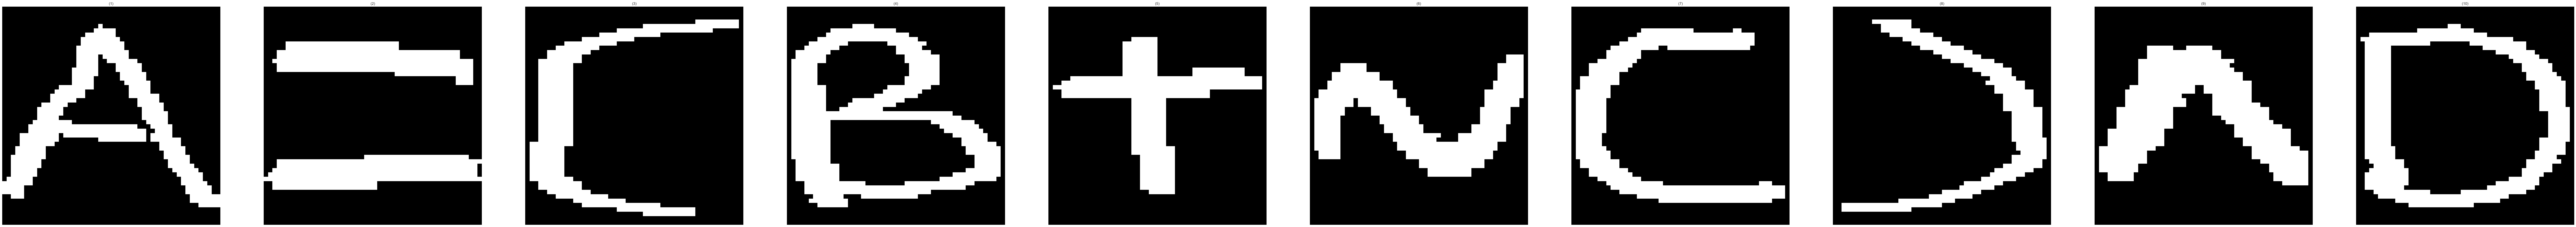

results
[5 8 0 6 2 9 7 1 5 3]
(10, 2916)
[5 8 0 6 2 9 7 1 5 3]
['A', 'F', '(', 'B', '+', '~', 'C', ')', 'A', '0']
['A', 'F', '(', 'B', '+', '~', 'C', ')', 'A', '0']


In [122]:
letters= cv2.cvtColor(cv2.imread(r"D:\academic_material\third_year\imageProcessing\repos\LogIm\phase_1\test_images\3.png"), cv2.COLOR_BGR2GRAY)
letters_res = np.array(get_letters(letters, single_letter=False, verbose=False))
cf.show_images(letters_res)
# letters_res = letters_res.reshape(len(letters_res), -1)
letters_res = np.array([hog.compute(image) for image in letters_res])

results = model.predict(letters_res)
print('results')
print(results)

# letters_res = letters_res.reshape(len(letters_res), -1)

print(letters_res.shape)

results = model.predict(letters_res)
print(results)
print([list(d.keys())[i] for i in results])
inv_map = {v: k for k, v in d.items()}
print([inv_map[i] for i in results])


In [123]:
import os
import PIL
import PIL.Image
import pandas as pd
import pathlib
import glob
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import seaborn as sns

def svm_model(X_train, X_test, y_train, y_test):
    from sklearn import svm
    svm_classifier = svm.SVC(kernel='rbf',gamma=0.001,C=5)
    svm_classifier.fit(X_train, y_train)
    predicted = svm_classifier.predict(X_test)
    accuracy = (len(X_test[predicted==y_test])/len(X_test))*100
    return  accuracy

def gaussian_naive_bayes(X_train, X_test, y_train, y_test):
    from sklearn.naive_bayes import GaussianNB
    GNB_classifier = GaussianNB()
    GNB_classifier.fit(X_train, y_train)
    predicted = GNB_classifier.predict(X_test)
    accuracy = (len(X_test[predicted == y_test]) / len(X_test)) * 100
    return accuracy

def decision_tree(X_train, X_test, y_train, y_test):
    from sklearn import tree
    dt_classifier = tree.DecisionTreeClassifier()
    dt_classifier.fit(X_train, y_train)
    predicted = dt_classifier.predict(X_test)
    accuracy = (len(X_test[predicted == y_test]) / len(X_test)) * 100
    return accuracy

def random_forest(X_train, X_test, y_train, y_test):
    from sklearn.ensemble import RandomForestClassifier
    RF_classifier = RandomForestClassifier( random_state=0)
    RF_classifier.fit(X_train, y_train)
    predicted = RF_classifier.predict(X_test)
    accuracy = (len(X_test[predicted == y_test]) / len(X_test)) * 100
    return accuracy

def k_nearest_neighbors(X_train, X_test, y_train, y_test):
    from sklearn.neighbors import KNeighborsClassifier
    KNN_classifier = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
    KNN_classifier.fit(X_train, y_train)
    predicted = KNN_classifier.predict(X_test)
    accuracy = (len(X_test[predicted == y_test]) / len(X_test)) * 100
    return accuracy

def stochastic_gradient_decend(X_train, X_test, y_train, y_test):
    from sklearn.linear_model import SGDClassifier
    sgd_classifier = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
    sgd_classifier.fit(X_train, y_train)
    predicted = sgd_classifier.predict(X_test)
    accuracy = (len(X_test[predicted == y_test]) / len(X_test)) * 100
    return accuracy

def xgboost(X_train, X_test, y_train, y_test):
    from xgboost import XGBClassifier
    model = XGBClassifier()
    model.fit(X_train, y_train)
    # make predictions for test data
    predicted = model.predict(X_test)
    accuracy = (len(X_test[predicted == y_test]) / len(X_test)) * 100
    return accuracy

def using_tsne(X_train,y_train):

    tsne = TSNE()
    X_embedded = tsne.fit_transform(X_train)
    sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1], hue=y_train, legend='full', palette=palette)
    plt.show()
    
    
    

svm_model_accuracy = svm_model(Xtrain, Xtest, ytrain, ytest)
print("svm accuracy:" + str(svm_model_accuracy))

gaussian_naive_bayes_accuracy = gaussian_naive_bayes(Xtrain, Xtest, ytrain, ytest)
print("gaussian naive bayes accuracy:" + str(gaussian_naive_bayes_accuracy))

decision_tree_accuracy = decision_tree(Xtrain, Xtest, ytrain, ytest)
print("decision tree accuracy:" + str(decision_tree_accuracy))

random_forest_accuracy = random_forest(Xtrain, Xtest, ytrain, ytest)
print("random forest accuracy:" + str(random_forest_accuracy))

knn_accuracy = k_nearest_neighbors(Xtrain, Xtest, ytrain, ytest)
print("knn accuracy:"+ str(knn_accuracy))

sgd = stochastic_gradient_decend(Xtrain, Xtest, ytrain, ytest)
print("stochastic gradient decent accuracy:" + str(sgd))

XGboost = xgboost(Xtrain, Xtest, ytrain, ytest)
print("xgboost accuracy:"+ str(XGboost))



svm accuracy:99.27536231884058
gaussian naive bayes accuracy:82.6086956521739
decision tree accuracy:83.33333333333334
random forest accuracy:98.55072463768117
knn accuracy:98.55072463768117
stochastic gradient decent accuracy:95.65217391304348


c:\Users\aatta\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\aatta\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


xgboost accuracy:97.10144927536231
